In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
import matplotlib.pyplot as plt

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
mnist.train.images[0].shape

(784,)

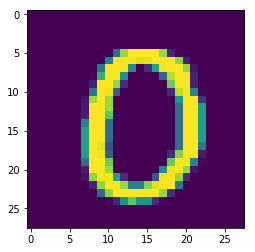

In [5]:
plt.imshow(mnist.train.images[10].reshape(28,28))
plt.show()

In [6]:
mnist.train.images[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [7]:
! python --version

Python 3.5.2


In [4]:
class VariationalInference(object):
    def __init__(self, n_datapoints, neurons_per_layer, mc_samples, batch_size):
        # SIZES
        self.N = n_datapoints
        self.layers = len(neurons_per_layer)
        self.neurons_per_layer = neurons_per_layer
        self.M = batch_size
        ## Set the number of Monte Carlo samples as a placeholder so that it can be different for training and test
        # self.L =  tf.placeholder(tf.int32)
        self.L = mc_samples
        
        ## Batch data placeholders
        with tf.name_scope('input'):
            self.X = tf.placeholder(tf.float32, shape=[None, neurons_per_layer[0]], name='x-input')
            self.Y = tf.placeholder(tf.float32, shape=[None, neurons_per_layer[-1]], name='y-input')
            
        with tf.name_scope('input_reshape'):
            image_shaped_input = tf.reshape(self.X, [-1, 28, 28, 1])
            tf.summary.image('input', image_shaped_input, 10)
        
        # PRIOR OF WEIGHTS
        self.prior_mean_W, self.log_prior_var_W = self.get_prior_W()
    
        # POSTERIOR OF WEIGHTS
        self.mean_W, self.log_var_W = self.init_posterior_W()
        ## Builds whole computational graph with relevant quantities as part of the class
        # self.loss, self.kl, self.ell, self.layer_out = self.get_nelbo()
        self.loss, self.kl, self.ell = self.get_nelbo()

        ## Initialize the session
        self.session = tf.Session()
    
    def variable_summaries(self, var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
                tf.summary.scalar('stddev', stddev)
                tf.summary.scalar('max', tf.reduce_max(var))
                tf.summary.scalar('min', tf.reduce_min(var))
                tf.summary.histogram('histogram', var)

    def get_prior_W(self):
        """
        Define a prior for the weight distribution.
        We assume them to be standard normal iid.
        """
        prior_mean_W = []
        log_prior_var_W = []
        
        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]
            
            with tf.name_scope("layer_" + str(i+1) + "_prior_weights"):
                prior_mean = tf.Variable(tf.zeros([d_in, d_out]), name="p_W")
                log_prior_var = tf.Variable(tf.zeros([d_in, d_out]), name="p_W")
                tf.summary.histogram('prior_mean', tf.reshape(prior_mean, [-1]))
                tf.summary.histogram('prior_logvar', tf.reshape(log_prior_var, [-1]))
            
            prior_mean_W.append(prior_mean)
            log_prior_var_W.append(log_prior_var)
        
        return prior_mean_W, log_prior_var_W

    def init_posterior_W(self):
        """
        The (variational) posterior is assumed to be
        drawn from P mutually independent normal distributions.
        Hence, we have a diagonal covariance matrix and only need to store an array.
        """
        mean_W = []
        log_var_W = []
        
        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]

            with tf.name_scope("layer_" + str(i+1) + "_posterior_weights"):
                post_mean = tf.Variable(tf.zeros([d_in, d_out]), name="q_W")
                post_log_var = tf.Variable(tf.zeros([d_in, d_out]), name="q_W")
                tf.summary.histogram('posterior_mean', tf.reshape(post_mean, [-1]))
                tf.summary.histogram('posterior_logvar', tf.reshape(post_log_var, [-1]))
            
            mean_W.append(post_mean)
            log_var_W.append(post_log_var)
            
        return mean_W, log_var_W
    
    def get_std_norm_samples(self, d_in, d_out):
        """
        Draws N(0,1) samples of dimension [d_in, d_out].
        """
        return tf.random_normal(shape=[d_in, d_out])

    def sample_from_W(self):
        """
        Samples from the variational posterior approximation.
        We draw W-samples for each layer using the reparameterization trick.
        """

        for i in range(self.layers - 1):
            d_in = self.neurons_per_layer[i] + 1 # + 1 because of bias weight
            d_out = self.neurons_per_layer[i+1]
            z = self.get_std_norm_samples(d_in, d_out)
            ## division by 2 to obtain pure standard deviation
            w_from_q = tf.add(tf.multiply(z, tf.exp(self.log_var_W[i] / 2)), self.mean_W[i])
        
            yield w_from_q
    
    def feedforward(self):
        """
        Feedforward pass excluding last layer's transfer function.
        """
        
        # We will generate L output samples
        for i in range(self.L):
            
            inputs = self.X
            
            # Go through each layer (one weight matrix at a time)
            # and compute the (intermediate) output
            j = 0
            for weight_matrix in self.sample_from_W():
                activations = tf.matmul(inputs, weight_matrix[1:,:]) + weight_matrix[0,:]
                # tf.summary.histogram('activations', activations)

                # if last layer is reached, do not use transfer function (softmax later on)
                if j == (self.layers - 2):
                    outputs = tf.sigmoid(activations)
                else:
                    outputs = tf.nn.softplus(activations)

                #outputs = tf.sigmoid(activations)
                #tf.summary.histogram('outputs', outputs)

                inputs = outputs
                j += 1
                
            # use generator to save memory space
            yield outputs
    
    def predict(self):
        """
        Predict using monte carlo sampling.
        """
        
        expected_output = 0
        
        for output in self.feedforward():
            expected_output += output
            
        return expected_output / self.L
    
    def get_ell(self):
        """
        Returns the expected log-likelihood of the lower bound.
        For this we draw L samples from W, compute the log-likelihood for each
        and average the log-likelihoods in the end (expectation approximation).
        """
        
        log_p = 0
        
        for output in self.feedforward():
            # y = tf.nn.softmax(tf.matmul(self.X, W_sample[i]) + b)
            # log_p_per_sample = tf.reduce_mean(tf.reduce_sum(self.Y * tf.log(y), reduction_indices=[1]))
            # soft_max_cross_entropy_with_logits is a numerically stable version of cross entropy
            # log_p_per_sample = tf.reduce_mean(-tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=self.Y))
            
            log_p_per_sample = tf.reduce_mean(tf.reduce_sum(
                                    self.Y * tf.log(output + 1e-10) + (1 - self.Y) * tf.log(1 - output + 1e-10),
                                    reduction_indices=[1]))
            log_p += log_p_per_sample
        
        return log_p / self.L

    def get_kl(self, mean_W, log_var_W, prior_mean_W, log_prior_var_W):
        """
        KL[q || p] returns the KL-divergence between the prior p and the variational posterior q.
        :param mq: vector of means for q
        :param log_vq: vector of log-variances for q
        :param mp: vector of means for p
        :param log_vp: vector of log-variances for p
        :return: KL divergence between q and p
        """
        mq = mean_W
        log_vq = log_var_W
        mp = prior_mean_W
        log_vp = log_prior_var_W
        
        #log_vp = tf.reshape(log_vp, (-1, 1))
        return 0.5 * tf.reduce_sum(log_vp - log_vq + (tf.pow(mq - mp, 2) / tf.exp(log_vp)) + tf.exp(log_vq - log_vp) - 1)

    def get_kl_multi(self):
        """
        Compute KL divergence between variational and prior using a multi-layer-network
        """
        kl = 0
        for i in range(self.layers - 1):
            kl = kl + self.get_kl(self.mean_W[i], self.log_var_W[i], self.prior_mean_W[i], self.log_prior_var_W[i])
        return kl
    
    def get_nelbo(self):
        """ Returns the negative ELBOW, which allows us to minimize instead of maximize. """
        kl = self.get_kl_multi()
        # ell, layer_out = self.get_ell()
        ell = self.get_ell()
        # DKL_gaussian - tf.mean([log_likelihood(w) for w in w_from_q])
        nelbo = kl - self.N/tf.cast(self.M, "float32") * ell
        # return nelbo, kl, ell, layer_out
        return nelbo, kl, ell
    
    def learn(self, learning_rate=0.01, epochs=50):
        """ Our learning procedure """
        optimizer = tf.train.AdamOptimizer(learning_rate)

        ## Set all_variables to contain the complete set of TF variables to optimize
        all_variables = tf.trainable_variables()

        ## Define the optimizer
        train_step = optimizer.minimize(self.loss, var_list=all_variables)

        tf.summary.scalar('negative_elbo', self.loss)
        tf.summary.scalar('kl_div', self.kl)
        tf.summary.scalar('ell', self.ell)
        
        merged = tf.summary.merge_all()
        
        train_writer = tf.summary.FileWriter('logs/train', self.session.graph)
        test_writer = tf.summary.FileWriter('logs/test')        
        
        ## Initialize all variables
        init = tf.global_variables_initializer()

        ## Initialize TF session
        self.session.run(init)

        ## Set the folder where the logs are going to be written 
        # summary_writer = tf.train.SummaryWriter('logs/', self.sessihttp://localhost:8888/notebooks/Bayesian%20Neural%20Network.ipynb#on.graph)
        #summary_writer = tf.summary.FileWriter('logs/', self.session.graph)
        
        for i in range(epochs):
            print("Epoch: ", i)
            
            for batch_i in range(mnist.train.num_examples // self.M):
                batch_xs, _ = mnist.train.next_batch(self.M)

                _, summary = self.session.run([train_step, merged], feed_dict={self.X: batch_xs, self.Y: batch_xs})
                train_writer.add_summary(summary, i)
            
            summary, nelbo = self.session.run([merged, self.get_nelbo()],
                                              feed_dict={self.X: mnist.test.images, self.Y: mnist.test.images})
            print("i=" + repr(i)  + "  kl=" + repr(nelbo[1]) + "  nell=" + repr(-nelbo[2])  + "  nelbo=" + repr(nelbo[0]), end="\n")
        
            test_writer.add_summary(summary, i)
        
        train_writer.close()
        test_writer.close()
        
    def test_pred(self, input_vector):
        output = self.predict()
        return self.session.run(output, feed_dict={self.X: input_vector, self.Y: mnist.test.images})
    
    def benchmark(self):
        output = self.predict()
        correct_prediction = tf.equal(tf.argmax(output,1),tf.argmax(self.Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(self.session.run(accuracy, feed_dict={self.X: mnist.test.images, self.Y: mnist.test.labels}))
        
    def debug(self):
        all_variables = tf.trainable_variables()
        init = tf.global_variables_initializer()
        self.session.run(init)
        print(self.session.run([self.prior_mean_W, self.log_prior_var_W], feed_dict={self.X: mnist.test.images, self.Y: mnist.test.labels}))

In [5]:
# n_datapoints, weight_dim, n_samples, batch_size

In [6]:
n_datapoints = mnist.train.num_examples
# including input neurons
mc_samples = 10
batch_size = 100
epochs = 10

In [10]:
# see if GPU support is enabled
tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [7]:
# n_datapoints, n_layers, neurons_per_layer, mc_samples, batch_size
neurons_per_layer = [784, 2048, 2048, 2, 2048, 2048, 784]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size)
vi.learn(learning_rate=0.01, epochs=epochs)

Epoch:  0


KeyboardInterrupt: 

In [8]:
type(mnist.test.images[0])

numpy.ndarray

In [10]:
import numpy as np

In [11]:
np.reshape(mnist.test.images[0], [1, -1]).shape

(1, 784)

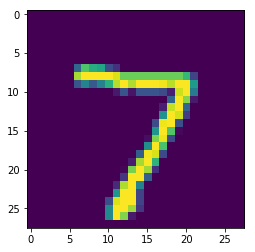

In [16]:
plt.imshow(mnist.test.images[0].reshape(28,28))
plt.show()

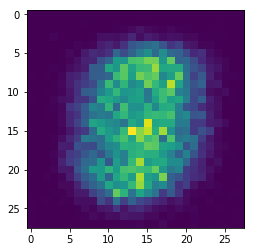

In [21]:
img_out = vi.test_pred(np.reshape(mnist.test.images[200], [1, -1]))

plt.imshow(img_out.reshape(28,28))
plt.show()

In [27]:
# n_datapoints, n_layers, neurons_per_layer, mc_samples, batch_size
neurons_per_layer = [784, 10, 10]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size)
mu, log_var_W_final = vi.learn(learning_rate=0.01, iterations=iterations)
vi.benchmark()

i=0  kl=0.40948671  nell=3.7837021  nelbo=2081.4456
i=100  kl=0.0097986162  nell=2.527931  nelbo=1390.3718
i=200  kl=0.0025273561  nell=2.44379  nelbo=1344.087
i=300  kl=0.004008472  nell=2.40974  nelbo=1325.361
i=400  kl=0.0078063905  nell=2.2114987  nelbo=1216.3322
i=500  kl=0.012652636  nell=2.0823584  nelbo=1145.3098
i=600  kl=0.016389519  nell=2.0481839  nelbo=1126.5175
i=700  kl=0.01134482  nell=2.0340207  nelbo=1118.7227
i=800  kl=0.0098190308  nell=2.0190938  nelbo=1110.5114
i=900  kl=0.012732029  nell=2.0130954  nelbo=1107.2152
i=1000  kl=0.0087222755  nell=1.9915596  nelbo=1095.3665
i=1100  kl=0.026929289  nell=1.9394716  nelbo=1066.7363
i=1200  kl=0.034531385  nell=1.8631294  nelbo=1024.7557
i=1300  kl=0.063946992  nell=1.7455273  nelbo=960.10394
i=1400  kl=0.050398767  nell=1.6979859  nelbo=933.94263
i=1500  kl=0.072067857  nell=1.6569531  nelbo=911.3963
i=1600  kl=0.07861957  nell=1.6340542  nelbo=898.80841
i=1700  kl=0.053618908  nell=1.6419401  nelbo=903.12067
i=1800  kl

In [28]:
neurons_per_layer = [784, 10, 10, 10]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size)
mu, log_var_W_final = vi.learn(learning_rate=0.01, iterations=iterations)
vi.benchmark()

i=0  kl=0.40487623  nell=3.7610855  nelbo=2069.0017
i=100  kl=0.012763292  nell=2.5673923  nelbo=1412.0786
i=200  kl=0.0024033487  nell=2.4512503  nelbo=1348.1901
i=300  kl=0.00085803866  nell=2.3622317  nelbo=1299.2283
i=400  kl=0.0012028217  nell=2.357306  nelbo=1296.5195
i=500  kl=0.0013866723  nell=2.3526604  nelbo=1293.9646
i=600  kl=0.00076860189  nell=2.335717  nelbo=1284.645
i=700  kl=0.00076407194  nell=2.3366673  nelbo=1285.1677
i=800  kl=0.001691401  nell=2.3222926  nelbo=1277.2626
i=900  kl=0.0010777712  nell=2.3226094  nelbo=1277.4363
i=1000  kl=0.0017136037  nell=2.3146696  nelbo=1273.0699
i=1100  kl=0.0012540817  nell=2.3191648  nelbo=1275.5419
i=1200  kl=0.0011963844  nell=2.3168225  nelbo=1274.2537
i=1300  kl=0.0020878315  nell=2.3139679  nelbo=1272.6844
i=1400  kl=0.0013838708  nell=2.309835  nelbo=1270.4105
i=1500  kl=0.003454268  nell=2.3049176  nelbo=1267.7081
i=1600  kl=0.055281848  nell=2.0548382  nelbo=1130.2163
i=1700  kl=0.097657859  nell=2.0248241  nelbo=1113

In [11]:
neurons_per_layer = [784, 10, 10, 10, 10]
vi = VariationalInference(n_datapoints, neurons_per_layer, mc_samples, batch_size)
mu, log_var_W_final = vi.learn(learning_rate=0.01, iterations=iterations)
vi.benchmark()

i=0  kl=0.41307092  nell=4.0774603  nelbo=2243.0164
i=100  kl=0.023146302  nell=2.7363048  nelbo=1504.9908
i=200  kl=0.0048297942  nell=2.4252973  nelbo=1333.9183
i=300  kl=0.0023159683  nell=2.3810675  nelbo=1309.5895
i=400  kl=0.0021038353  nell=2.3753421  nelbo=1306.4403
i=500  kl=0.0023694932  nell=2.3523958  nelbo=1293.8199
i=600  kl=0.0012452602  nell=2.3467257  nelbo=1290.7003
i=700  kl=0.00090840459  nell=2.3342929  nelbo=1283.8619
i=800  kl=0.0014319122  nell=2.3260868  nelbo=1279.3492
i=900  kl=0.00095486641  nell=2.3189051  nelbo=1275.3988
i=1000  kl=0.00072363019  nell=2.32341  nelbo=1277.8762
i=1100  kl=0.0011562705  nell=2.3174789  nelbo=1274.6145
i=1200  kl=0.0013821721  nell=2.3109155  nelbo=1271.0049
i=1300  kl=0.0036362112  nell=2.3148322  nelbo=1273.1614
i=1400  kl=0.002412647  nell=2.3137445  nelbo=1272.5619
i=1500  kl=0.0027191937  nell=2.3131518  nelbo=1272.2362
i=1600  kl=0.0019071698  nell=2.3109798  nelbo=1271.0409
i=1700  kl=0.003613621  nell=2.3094106  nelbo=